In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, SGD
from keras import regularizers

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
df = pd.read_csv('train.csv')
df.head()

Using TensorFlow backend.


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


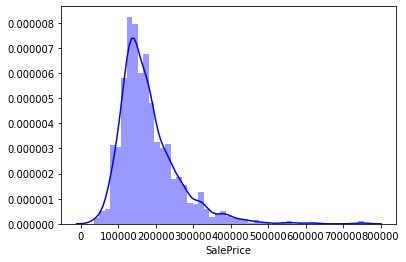

In [8]:
# Analysis of the dependent variable
sns.distplot(df['SalePrice'], color='blue')
plt.show()

# ich kann Gamma Regression verwende oder ein normales neurales Netz oder OLS nach einer Log Transformation!

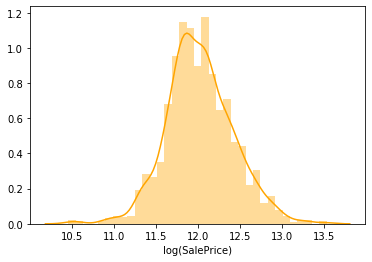

In [3]:
sns.distplot(np.log(df['SalePrice']), color='orange')
plt.xlabel('log(SalePrice)')
plt.show()

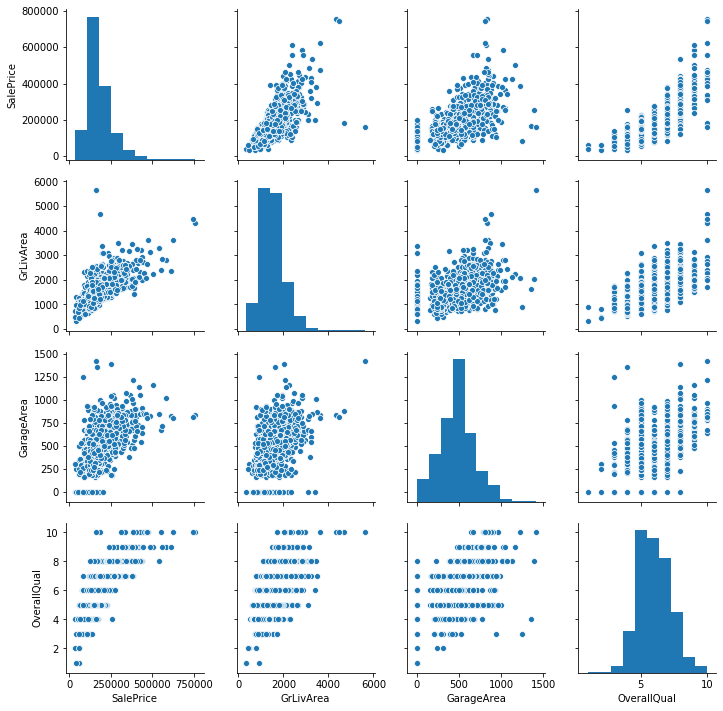

In [4]:
# Analysis of (highly correlated) independent variables
df1 = df[['SalePrice','GrLivArea','GarageArea','OverallQual']]
# Metric independent variables
sns.pairplot(df1 )
plt.show()

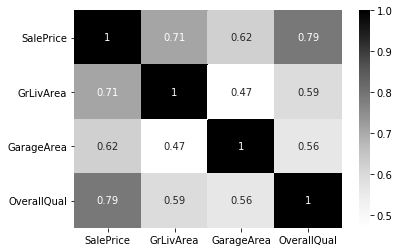

In [5]:
sns.heatmap(df1.corr(), annot=True , cmap='Greys')
plt.show()

## Preprocessing

In [6]:



df.loc[df['ExterQual'] == 'Ex','ExterQual'] = 5
df.loc[df['ExterQual'] == 'Gd','ExterQual'] = 4
df.loc[df['ExterQual'] == 'TA','ExterQual'] = 3
df.loc[df['ExterQual'] == 'Fa','ExterQual'] = 2

df.loc[df['BsmtFinType1'] == 'GLQ','BsmtFinType1'] = 6
df.loc[df['BsmtFinType1'] == 'ALQ','BsmtFinType1'] = 5
df.loc[df['BsmtFinType1'] == 'BLQ','BsmtFinType1'] = 4
df.loc[df['BsmtFinType1'] == 'Rec','BsmtFinType1'] = 3
df.loc[df['BsmtFinType1'] == 'LwQ','BsmtFinType1'] = 2
df.loc[df['BsmtFinType1'] == 'Unf','BsmtFinType1'] = 1 

df.loc[df['BsmtQual'] == 'Ex','BsmtQual'] = 5
df.loc[df['BsmtQual'] == 'Gd','BsmtQual'] = 4
df.loc[df['BsmtQual'] == 'TA','BsmtQual'] = 3
df.loc[df['BsmtQual'] == 'Fa','BsmtQual'] = 2
df.loc[df['BsmtQual'] == 'Po','BsmtQual'] = 1  

df.loc[df['Functional'] == 'Typ','Functional'] = 7
df.loc[df['Functional'] == 'Min1','Functional'] = 6
df.loc[df['Functional'] == 'Min2','Functional'] = 5
df.loc[df['Functional'] == 'Mod','Functional'] = 4
df.loc[df['Functional'] == 'Maj1','Functional'] = 3
df.loc[df['Functional'] == 'Maj2','Functional'] = 2
df.loc[df['Functional'] == 'Sev','Functional'] = 1

df.loc[df['HeatingQC'] == 'Ex','HeatingQC'] = 5
df.loc[df['HeatingQC'] == 'Gd','HeatingQC'] = 4
df.loc[df['HeatingQC'] == 'TA','HeatingQC'] = 3
df.loc[df['HeatingQC'] == 'Fa','HeatingQC'] = 2
df.loc[df['HeatingQC'] == 'Po','HeatingQC'] = 1  

df.loc[df['FireplaceQu'] == 'Ex','FireplaceQu'] = 5
df.loc[df['FireplaceQu'] == 'Gd','FireplaceQu'] = 4
df.loc[df['FireplaceQu'] == 'TA','FireplaceQu'] = 3
df.loc[df['FireplaceQu'] == 'Fa','FireplaceQu'] = 2
df.loc[df['FireplaceQu'] == 'Po','FireplaceQu'] = 1 


df1=df.select_dtypes(exclude=['object'])

df_dummies=pd.concat([pd.get_dummies(df['ExterQual'], prefix='ExterQual',drop_first=True),
                      pd.get_dummies(df['BsmtQual'], prefix='BsmtQual',drop_first=True),
                      pd.get_dummies(df['HeatingQC'], prefix='HeatingQC',drop_first=True),
                      pd.get_dummies(df['BsmtFinType1'], prefix='BsmtFinType1',drop_first=True),
                      pd.get_dummies(df['Functional'], prefix='Functional',drop_first=True),
                      pd.get_dummies(df['FireplaceQu'], prefix='FireplaceQu',drop_first=True)],axis=1)

df_metric=df1['LotFrontage LotArea YearBuilt GrLivArea FullBath Fireplaces GarageArea SalePrice'.split()]

df_final=pd.concat([df_dummies, df1['LotFrontage LotArea YearBuilt GrLivArea FullBath Fireplaces GarageArea SalePrice'.split()]],axis=1)
df_final = df_final[df_final['GrLivArea'] < 4000]
df_final.dropna(inplace=True)

In [7]:

# Train and test data
X = df_final.drop(['SalePrice'], axis=1)
y_level = df_final['SalePrice']
y_log=np.log(df_final['SalePrice'])
from sklearn.model_selection import train_test_split
x_train , x_test , y_level_train , y_level_test = train_test_split(X, y_level, test_size =0.3, random_state =77)
x_train , x_test , y_log_train , y_log_test = train_test_split(X, y_log, test_size =0.3, random_state =77)



### scale the variables: man skaliert auf training date dann test data
from sklearn.preprocessing import StandardScaler
SC= StandardScaler().fit(x_train['LotFrontage LotArea YearBuilt GrLivArea FullBath Fireplaces GarageArea'.split()])
x_train['LotFrontage LotArea YearBuilt GrLivArea FullBath Fireplaces GarageArea'.split()]=SC.transform(x_train['LotFrontage LotArea YearBuilt GrLivArea FullBath Fireplaces GarageArea'.split()])
x_test['LotFrontage LotArea YearBuilt GrLivArea FullBath Fireplaces GarageArea'.split()]=SC.transform(x_test['LotFrontage LotArea YearBuilt GrLivArea FullBath Fireplaces GarageArea'.split()])



# ich sollte mal verlgeichen OLS mit Log Transoformation , Gamma Resgression und ein normales neurales Netz
# OLS

In [9]:
OLS_fit=sm.OLS(y_log_train,sm.add_constant(x_train)).fit()
print(OLS_fit.summary())


OLS_pred_IS=np.exp(OLS_fit.predict(sm.add_constant(x_train))) + np.var(OLS_fit.resid)/2


                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     117.6
Date:                Sun, 12 Jan 2020   Prob (F-statistic):          1.41e-274
Time:                        17:40:27   Log-Likelihood:                 266.24
No. Observations:                 837   AIC:                            -468.5
Df Residuals:                     805   BIC:                            -317.1
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -6.363e+10   1.23e+12     -0.

In [10]:
OLS_pred_OOS=np.exp(OLS_fit.predict(sm.add_constant(x_test))) + np.var(OLS_fit.resid)/2
print('RMSE In Sample OLS      : ',np.sqrt(mean_squared_error(y_level_train,OLS_pred_IS)))
print('RMSE Out of Sample OLS  : ',np.sqrt(mean_squared_error(y_level_test,OLS_pred_OOS)))

RMSE In Sample OLS      :  32679.954836604316
RMSE Out of Sample OLS  :  33585.169768020314


# Gamma Regression

In [11]:
model = sm.GLM(y_level_train,x_train,
family=sm.families.Gamma(link = sm.genmod.families.links.log)).fit()
print(model.summary ())


                 Generalized Linear Model Regression Results                  
Dep. Variable:              SalePrice   No. Observations:                  837
Model:                            GLM   Df Residuals:                      805
Model Family:                   Gamma   Df Model:                           31
Link Function:                    log   Scale:                        0.020053
Method:                          IRLS   Log-Likelihood:                -9616.1
Date:                Sun, 12 Jan 2020   Deviance:                       17.387
Time:                        17:40:39   Pearson chi2:                     16.1
No. Iterations:                    15                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
ExterQual_3        0.2695      0.052      5.

In [12]:
Gamma_pred_IS=model.predict(x_train)
Gamma_pred_OOS=model.predict(x_test)
print('RMSE In Sample Gamma    : ',np.sqrt(mean_squared_error(y_level_train,Gamma_pred_IS)))
print('RMSE Out of Sample Gamma: ',np.sqrt(mean_squared_error(y_level_test,Gamma_pred_OOS)))

RMSE In Sample Gamma    :  27221.030761628743
RMSE Out of Sample Gamma:  29314.849531888394


# Neural Network

## Hyperparameters

In [13]:
#Learningrate
LR=0.005
# Number of neurons
Neuron_Out=1
Neuron_Hidden=512
Neuron_Hidden_2=int(Neuron_Hidden/2)

#The Activation function
Activate_output='linear' # output activation function is linear
Activate_hidden='relu'
#The Optimizer
Optimizer= Adam(lr=LR)
# The loss function
loss='mean_absolute_error'

## hier findet " Dropout" die Anwendung

In [14]:
#Initialize the ANN
model_ANN= Sequential()
# Hidden Layer
model_ANN.add(Dense(Neuron_Hidden, activation=Activate_hidden, input_shape=(32,), use_bias=True,kernel_regularizer=regularizers.l1(0.01)))
model_ANN.add(Dropout(0.45)) # Droput
model_ANN.add(Dense(Neuron_Hidden_2, activation=Activate_hidden, use_bias=True,kernel_regularizer=regularizers.l1(0.01)))
model_ANN.add(Dropout(0.45))
#Output Layer
model_ANN.add(Dense(Neuron_Out, activation=Activate_output,use_bias=True))
model_ANN.summary()
model_ANN.compile(optimizer=Optimizer , loss=loss)

#Fit the model
history_ANN=model_ANN.fit(
x_train, # training data
y_level_train, # training targets
epochs=1500,verbose=1,batch_size=256)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               16896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 148,481
Trainable params: 148,481
Non-trainable params: 0
_________________________________________________________________


Epoch 1/1500
83

837/837 [==============================] - 0s 161us/step - loss: 23453.8919
Epoch 153/1500
837/837 [==============================] - 0s 185us/step - loss: 22627.0684
Epoch 154/1500
837/837 [==============================] - 0s 211us/step - loss: 23885.3376
Epoch 155/1500
837/837 [==============================] - 0s 206us/step - loss: 22603.9256
Epoch 156/1500
837/837 [==============================] - 0s 206us/step - loss: 23725.1074
Epoch 157/1500
837/837 [==============================] - 0s 200us/step - loss: 22425.7324
Epoch 158/1500
837/837 [==============================] - 0s 164us/step - loss: 22680.1603
Epoch 159/1500
837/837 [==============================] - 0s 151us/step - loss: 22564.6842
Epoch 160/1500
837/837 [==============================] - 0s 148us/step - loss: 22341.5637
Epoch 161/1500
837/837 [==============================] - 0s 146us/step - loss: 22982.7986
Epoch 162/1500
837/837 [==============================] - 0s 153us/step - loss: 22717.7099
Epoch 163/1500

837/837 [==============================] - 0s 151us/step - loss: 21622.5649
Epoch 333/1500
837/837 [==============================] - 0s 148us/step - loss: 22643.0392
Epoch 334/1500
837/837 [==============================] - 0s 144us/step - loss: 22101.3418
Epoch 335/1500
837/837 [==============================] - 0s 146us/step - loss: 21120.0156
Epoch 336/1500
837/837 [==============================] - 0s 146us/step - loss: 23318.8258
Epoch 337/1500
837/837 [==============================] - 0s 150us/step - loss: 22851.8434
Epoch 338/1500
837/837 [==============================] - 0s 146us/step - loss: 22478.6421
Epoch 339/1500
837/837 [==============================] - 0s 147us/step - loss: 21918.1096
Epoch 340/1500
837/837 [==============================] - 0s 147us/step - loss: 22093.9333
Epoch 341/1500
837/837 [==============================] - 0s 147us/step - loss: 22246.2933
Epoch 342/1500
837/837 [==============================] - 0s 148us/step - loss: 22189.5171
Epoch 343/1500

837/837 [==============================] - 0s 152us/step - loss: 22428.8902
Epoch 513/1500
837/837 [==============================] - 0s 148us/step - loss: 21198.7914
Epoch 514/1500
837/837 [==============================] - 0s 146us/step - loss: 21436.6441
Epoch 515/1500
837/837 [==============================] - 0s 147us/step - loss: 21588.5062
Epoch 516/1500
837/837 [==============================] - 0s 151us/step - loss: 21631.8606
Epoch 517/1500
837/837 [==============================] - 0s 146us/step - loss: 22453.0781
Epoch 518/1500
837/837 [==============================] - 0s 148us/step - loss: 21337.7212
Epoch 519/1500
837/837 [==============================] - 0s 151us/step - loss: 21694.4260
Epoch 520/1500
837/837 [==============================] - 0s 147us/step - loss: 22113.4659
Epoch 521/1500
837/837 [==============================] - 0s 149us/step - loss: 21305.0415
Epoch 522/1500
837/837 [==============================] - 0s 146us/step - loss: 21898.4880
Epoch 523/1500

837/837 [==============================] - 0s 153us/step - loss: 20969.6927
Epoch 693/1500
837/837 [==============================] - 0s 146us/step - loss: 21807.4271
Epoch 694/1500
837/837 [==============================] - 0s 151us/step - loss: 21729.5593
Epoch 695/1500
837/837 [==============================] - 0s 147us/step - loss: 21011.5328
Epoch 696/1500
837/837 [==============================] - 0s 148us/step - loss: 21134.6891
Epoch 697/1500
837/837 [==============================] - 0s 147us/step - loss: 21353.5661
Epoch 698/1500
837/837 [==============================] - 0s 147us/step - loss: 21134.4592
Epoch 699/1500
837/837 [==============================] - 0s 144us/step - loss: 21260.1214
Epoch 700/1500
837/837 [==============================] - 0s 147us/step - loss: 21532.7456
Epoch 701/1500
837/837 [==============================] - 0s 147us/step - loss: 20754.2825
Epoch 702/1500
837/837 [==============================] - 0s 160us/step - loss: 22362.8991
Epoch 703/1500

837/837 [==============================] - 0s 151us/step - loss: 20725.7277
Epoch 873/1500
837/837 [==============================] - 0s 147us/step - loss: 21096.3818
Epoch 874/1500
837/837 [==============================] - 0s 146us/step - loss: 20746.0400
Epoch 875/1500
837/837 [==============================] - 0s 148us/step - loss: 20753.9501
Epoch 876/1500
837/837 [==============================] - 0s 152us/step - loss: 21517.6873
Epoch 877/1500
837/837 [==============================] - 0s 147us/step - loss: 20786.1822
Epoch 878/1500
837/837 [==============================] - 0s 149us/step - loss: 21816.7728
Epoch 879/1500
837/837 [==============================] - 0s 147us/step - loss: 21399.1619
Epoch 880/1500
837/837 [==============================] - 0s 149us/step - loss: 21744.0423
Epoch 881/1500
837/837 [==============================] - 0s 147us/step - loss: 21803.5392
Epoch 882/1500
837/837 [==============================] - 0s 148us/step - loss: 21146.5164
Epoch 883/1500

837/837 [==============================] - 0s 159us/step - loss: 21359.8599
Epoch 1052/1500
837/837 [==============================] - 0s 156us/step - loss: 20986.2112
Epoch 1053/1500
837/837 [==============================] - 0s 165us/step - loss: 21286.7801
Epoch 1054/1500
837/837 [==============================] - 0s 151us/step - loss: 20823.9696
Epoch 1055/1500
837/837 [==============================] - 0s 153us/step - loss: 20547.3154
Epoch 1056/1500
837/837 [==============================] - 0s 150us/step - loss: 20596.5575
Epoch 1057/1500
837/837 [==============================] - 0s 212us/step - loss: 22038.3562
Epoch 1058/1500
837/837 [==============================] - 0s 192us/step - loss: 21382.3186
Epoch 1059/1500
837/837 [==============================] - 0s 157us/step - loss: 20737.7412
Epoch 1060/1500
837/837 [==============================] - 0s 162us/step - loss: 21123.3027
Epoch 1061/1500
837/837 [==============================] - 0s 164us/step - loss: 22084.5745
Epoc

837/837 [==============================] - 0s 150us/step - loss: 20300.4947
Epoch 1230/1500
837/837 [==============================] - 0s 152us/step - loss: 21847.9336
Epoch 1231/1500
837/837 [==============================] - 0s 145us/step - loss: 20723.3021
Epoch 1232/1500
837/837 [==============================] - 0s 147us/step - loss: 20859.8578
Epoch 1233/1500
837/837 [==============================] - 0s 145us/step - loss: 21573.6009
Epoch 1234/1500
837/837 [==============================] - 0s 151us/step - loss: 21318.6827
Epoch 1235/1500
837/837 [==============================] - 0s 188us/step - loss: 21054.7172
Epoch 1236/1500
837/837 [==============================] - 0s 269us/step - loss: 20822.2275
Epoch 1237/1500
837/837 [==============================] - 0s 235us/step - loss: 21847.5422
Epoch 1238/1500
837/837 [==============================] - 0s 166us/step - loss: 21515.4911
Epoch 1239/1500
837/837 [==============================] - 0s 161us/step - loss: 20535.7243
Epoc

837/837 [==============================] - 0s 151us/step - loss: 19945.1878
Epoch 1408/1500
837/837 [==============================] - 0s 146us/step - loss: 20483.7609
Epoch 1409/1500
837/837 [==============================] - 0s 145us/step - loss: 19770.5033
Epoch 1410/1500
837/837 [==============================] - 0s 154us/step - loss: 20545.3989
Epoch 1411/1500
837/837 [==============================] - 0s 148us/step - loss: 20445.6578
Epoch 1412/1500
837/837 [==============================] - 0s 148us/step - loss: 20405.3639
Epoch 1413/1500
837/837 [==============================] - 0s 147us/step - loss: 20729.5708
Epoch 1414/1500
837/837 [==============================] - 0s 146us/step - loss: 20430.9104
Epoch 1415/1500
837/837 [==============================] - 0s 146us/step - loss: 20881.6600
Epoch 1416/1500
837/837 [==============================] - 0s 147us/step - loss: 20518.5151
Epoch 1417/1500
837/837 [==============================] - 0s 147us/step - loss: 20543.2760
Epoc

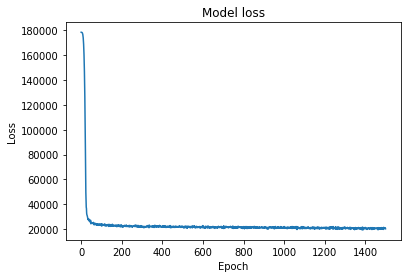

In [15]:
ANN_pred_IS=model_ANN.predict(x_train)
ANN_pred_OOS=model_ANN.predict(x_test)


plt.plot(history_ANN.history['loss'])
#plt.plot(history_ANN.history['val_acc'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# In Sample Comparison

In [16]:
print('RMSE In Sample ANN  : ',np.sqrt(mean_squared_error(y_level_train,ANN_pred_IS)))
print('RMSE In Sample Gamma: ',np.sqrt(mean_squared_error(y_level_train,Gamma_pred_IS)))
print('RMSE In Sample OLS  : ',np.sqrt(mean_squared_error(y_level_train,OLS_pred_IS)))

# Mean squared error bei NN ist wenig im Vergleich zu Sample Gamma und Sample OLS
# ich kann In Sample error bei NN weniger machen! wie? durch mehr Trainieren -> also mehr epochen!

RMSE In Sample ANN  :  24694.779203573627
RMSE In Sample Gamma:  27221.030761628743
RMSE In Sample OLS  :  32679.954836604316


# Out of Sample Comparision

In [17]:
print('RMSE Out of Sample ANN  : ',np.sqrt(mean_squared_error(y_level_test,ANN_pred_OOS)))
print('RMSE Out of Sample Gamma: ',np.sqrt(mean_squared_error(y_level_test,Gamma_pred_OOS)))
print('RMSE Out of Sample OLS  : ',np.sqrt(mean_squared_error(y_level_test,OLS_pred_OOS)))

# bei NN Out of Sample ist wichtiger

RMSE Out of Sample ANN  :  28685.293330961274
RMSE Out of Sample Gamma:  29314.849531888394
RMSE Out of Sample OLS  :  33585.169768020314
